In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Siapkan fungsi daret waktu yang akan digunakan untuk perhitungan nantinya

In [2]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
tf.random.set_seed(7)

# 2. Gunakan dataset

In [4]:
df = read_csv('airline-passengers.csv', sep=",")
df = df.drop(['Month'], axis=1)
display(df)
dataset = df.astype('float32')
print(dataset)

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


     Passengers
0         112.0
1         118.0
2         132.0
3         129.0
4         121.0
..          ...
139       606.0
140       508.0
141       461.0
142       390.0
143       432.0

[144 rows x 1 columns]


# 3. Lakukan normalisasi min-max pada dataset

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset)

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.1911197 ]
 [0.24

# 4. Pisahkan data yang digunakan untuk train dan test

##### mengambil data 67% untuk digunakan sebagai train_size dan sisanya digunakan sebagai tesgt_size
##### "train = dataset[0:train_size, :]" = berarti bahwa mengambil data pada dataset yang dimulai dengan index ke 0 hingga sepanjang index hasil perhitungan train_test yang telah dihitung.
##### "test = dataset[train_size:len(dataset), :]" = berarti bahwa mengambil data yang dimulai dari index hasil perhitungan train_size hingga akhir.

In [6]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
print(f"""Berikut adalah hasil dari train dan test
{train_size}, {test_size}""")

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(dataset)

Berikut adalah hasil dari train dan test
96, 48
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]


# 5. Buat bentuk data menjadi siap untuk LSTM

##### look_back = berapa banyak data sebelumnya yang akan dilihat untuk menjadi dasar dalam pengambilan keputusan
##### gunakan fungsi create_dataset sebelumnya untuk melakkan proses train dan test
- trainX, trainY = dianggap sebagai dataX, dataY pada fungsi create_dataset
- testX, testY = dianggap sebagai dataX, dataY pada fungsi create_dataset

### Pembentukkan trainX, trainY, testX, testY memiliki fungsi:
1. trainX adalah data input yang digunakan untuk melatih model.
   - trainX adalah data masukan yang digunakan untuk melatih model kita. Dalam hal ini, data yang ada di trainX adalah data historis atau data yang sudah ada, yang kita gunakan untuk membuat model kita "belajar" pola-pola yang ada. 
   - Misalnya, jika kita memprediksi jumlah penumpang pesawat per bulan, maka trainX adalah data bulan-bulan sebelumnya yang digunakan untuk memprediksi bulan berikutnya.
2. trainY adalah data target atau output yang kita ingin model prediksi dari trainX.
   - jawaban yang benar atau target yang kita harapkan setelah model melakukan prediksi berdasarkan trainX. 
   - trainY adalah data yang berisi nilai yang ingin kita prediksi (misalnya, jumlah penumpang pesawat di bulan yang akan datang berdasarkan data bulan sebelumnya yang ada di trainX).
3. testX adalah data input yang digunakan untuk menguji model setelah dilatih.
   - data masukan yang digunakan untuk mengukur seberapa baik model yang telah dilatih bekerja pada data yang belum dilihat sebelumnya. 
   - testX berisi data yang tidak digunakan saat pelatihan, tetapi digunakan untuk menguji apakah model kita bisa memberikan hasil yang akurat pada data yang baru.
4. testY adalah data target yang benar, digunakan untuk membandingkan hasil prediksi model dengan data yang sebenarnya.
   -  jawaban yang benar atau target yang seharusnya diprediksi oleh model pada saat pengujian dengan menggunakan data testX. Ini digunakan untuk mengukur akurasi model dengan cara membandingkan hasil prediksi dengan data yang sudah kita tahu.

In [7]:
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(f"""Berikut adalah hasil dari trainX:
{trainX}
Berikut adalah hasil dari trainY:
{trainY}
Berikut adalah hasil dari testX:
{testX}
Berikut adalah hasil dari testY:
{testY}""")

Berikut adalah hasil dari trainX:
[[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
  0.08494207 0.08494207 0.06177607 0.02895753 0.         0.02702703]
 [0.02702703 0.05405405 0.04826255 0.03281853 0.05984557 0.08494207
  0.08494207 0.06177607 0.02895753 0.         0.02702703 0.02123553]
 [0.05405405 0.04826255 0.03281853 0.05984557 0.08494207 0.08494207
  0.06177607 0.02895753 0.         0.02702703 0.02123553 0.04247104]
 [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207 0.06177607
  0.02895753 0.         0.02702703 0.02123553 0.04247104 0.07142857]
 [0.03281853 0.05984557 0.08494207 0.08494207 0.06177607 0.02895753
  0.         0.02702703 0.02123553 0.04247104 0.07142857 0.05984557]
 [0.05984557 0.08494207 0.08494207 0.06177607 0.02895753 0.
  0.02702703 0.02123553 0.04247104 0.07142857 0.05984557 0.04054055]
 [0.08494207 0.08494207 0.06177607 0.02895753 0.         0.02702703
  0.02123553 0.04247104 0.07142857 0.05984557 0.04054055 0.08687258]
 [0.08494207 0.

#### Proses reshape penting dalam LSTM untuk menerima input dalam bentuk 3D: (samples, timesteps, features).
Pada proses reshape, data akan diubah menjadi arsitektur LSTM (samples, timesteps, features).
contoh:
1. data matriks seperti berikut:

trainX = np.array([

    [1, 2, 3],
    
    [4, 5, 6],
    
    [7, 8, 9],
    
    [10, 11, 12]
    
])

2. (trainX.shape[0], 1, trainX.shape[1])
3. berarti berdasarkan (samples, timesteps, features):
   - trainX.shape[0] digunakan sebagai jumlah total samples yaitu ada 4.
   - 1 digunakan sebagai data timesteps, yang menggambarkan 1 timesteps terdiri dari 3 fitur.
   - trainX.shape[1] digunakan sebagai jumlah total features dalam setiap samples yaitu ada 3 fitur dalam setiap sample.
4. Hasil reshape adalah sebagai berikut
 
[[[ 1,  2,  3]],    <-- Sample 1, timestep 1, features [1, 2, 3]

 [[ 4,  5,  6]],    <-- Sample 2, timestep 1, features [4, 5, 6]  
 
 [[ 7,  8,  9]],    <-- Sample 3, timestep 1, features [7, 8, 9] 
 
 [[10, 11, 12]],    <-- Sample 4, timestep 1, features [10, 11, 12] 
 
 [[13, 14, 15]]]    <-- Sample 5, timestep 1, features [13, 14, 15] 
 
 #### Reshape dilakukan pada trainX dan testX dikarenakan data tersebut yang akan digunakan untuk proses pelatihan sedangkan y hanya sebagai output sehingga y tidak perlu dilakukan reshape

In [8]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 6. Desain algoritma LSTM

### model = Sequential()
Sequential(): Bayangkan model ini seperti tumpukan lego, di mana kita menambah lapisan demi lapisan. Sequential adalah alat yang membantu kita membuat tumpukan model ini dengan mudah.

### 1. model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))

##### model.add(LSTM(50, ....))
- Menambahkan lapisan LSTM pertama dengan 50 unit atau neuron.
- Setiap unit atau neuron LSTM memiliki cell state dan hidden state yang dapat mempertahankan informasi jangka panjang, sehingga membantu mempelajari pola di data deret waktu.

LSTM(50): LSTM adalah bagian dari model yang sangat pintar dalam mengingat pola-pola dari masa lalu. Misalnya, model ini akan melihat jumlah penumpang selama 12 bulan terakhir untuk mempelajari apakah ada pola yang berulang. Jadi, kalau bulan-bulan tertentu selalu ramai, dia bisa “mengingatnya” dan memprediksi bulan berikutnya dengan lebih baik.

##### input_shape=(1, look_back)
- bentuk asli adalah (time_steps, features)
- time_steps = 1: Artinya model membaca satu urutan titik data dalam satu langkah waktu (ini sering digunakan dalam data deret waktu yang diubah ke dalam bentuk [samples, time_steps, features]).
- features = look_back: Jumlah features adalah look_back, yaitu jumlah titik data sebelumnya yang ingin diamati oleh model untuk memprediksi nilai berikutnya.

input_shape=(1, look_back): Ini memberitahu model bahwa setiap kali melihat data, kita ingin dia memperhatikan 12 bulan sebelumnya, satu per satu, agar ia bisa mengenali pola.

##### return_sequences=True
- Memastikan bahwa lapisan LSTM pertama mengeluarkan seluruh rangkaian (sequence) keluaran, bukan hanya keluaran terakhir.
- Ketika return_sequences=True, output dari setiap langkah waktu di LSTM pertama akan diteruskan ke lapisan berikutnya. Ini memungkinkan lapisan berikutnya menerima seluruh rangkaian keluaran untuk menangkap pola yang lebih kompleks.

return_sequences=True: Ini seperti menyuruh model untuk terus mengalirkan informasi dari setiap bulan sebelumnya ke bulan berikutnya. Jadi, model akan mengingat informasi dari setiap bulan, bukan hanya mengambil hasil akhir saja.

### 2. model.add(LSTM(50))
- Menambahkan lapisan LSTM kedua dengan 50 unit (neuron).
- Pada lapisan ini, return_sequences=False secara default, artinya lapisan ini hanya mengeluarkan keluaran terakhir dari urutan waktu, bukan seluruh urutan.
- Hal ini cocok untuk menyimpulkan output akhir yang akan digunakan untuk prediksi, karena output akhir dari LSTM ini akan diteruskan ke lapisan Dense untuk memprediksi nilai target.
- Lapisan ini menangkap pola yang lebih kompleks dan mempelajari urutan dari keluaran lapisan pertama, yang mencerminkan pola jangka panjang dan jangka pendek.

Lapisan ini juga pintar dalam mengingat pola, tetapi di sini kita hanya ingin hasil akhirnya saja. Lapisan ini akan mengambil semua informasi dari bulan-bulan sebelumnya dan membuat satu kesimpulan besar. Dengan begitu, model ini jadi lebih siap untuk membuat prediksi bulan berikutnya.

### 3. model.add(Dense(1))
- Menambahkan lapisan Dense (lapisan fully connected) dengan 1 neuron.
- Fungsi lapisan ini adalah menghasilkan output akhir (dalam hal ini, memprediksi nilai penumpang pada bulan berikutnya).
- Karena masalah ini adalah regresi (prediksi nilai kontinu), neuron ini tidak memiliki fungsi aktivasi tambahan. Neuron ini menerima nilai keluaran dari LSTM sebelumnya dan menghasilkan prediksi.

Dense(1): Lapisan ini seperti lembar jawaban. Setelah model memproses semua data, ia akan menghasilkan satu angka di sini, yaitu tebakan jumlah penumpang di bulan berikutnya. Ibaratnya, ini adalah jawaban akhir model setelah melihat semua pola.

### 4. model.compile(loss='mean_squared_error', optimizer='adam')

##### loss='mean_squared_error'
- Fungsi kehilangan yang digunakan adalah Mean Squared Error (MSE), yang sering digunakan dalam masalah regresi. MSE mengukur rata-rata dari kuadrat kesalahan antara prediksi dan nilai sebenarnya. Semakin rendah nilai MSE, semakin akurat prediksi model.

loss='mean_squared_error': Ini adalah cara menghitung kesalahan model, atau seberapa jauh tebakan model dari jawaban yang benar. Model akan terus mencoba menurunkan kesalahan ini, jadi semakin lama semakin akurat.

##### optimizer='adam'
- Optimizer yang digunakan adalah Adam (Adaptive Moment Estimation), yang merupakan kombinasi dari momentum dan RMSprop. Adam adalah pilihan umum karena biasanya memberikan konvergensi yang lebih cepat dan stabil dalam banyak kasus. Adam secara otomatis menyesuaikan laju belajar selama pelatihan.

optimizer='adam': Optimizer ini seperti alat bantu untuk mempercepat model belajar. Jadi, "Adam" membantu model untuk belajar dengan cepat dan efisien.

### 5. early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

##### monitor='val_loss'
- Mengarahkan callback untuk memantau metrik val_loss (kerugian pada data validasi) untuk menentukan kapan pelatihan harus dihentikan. Ketika val_loss berhenti menurun, berarti model sudah mencapai batas kinerjanya pada data baru.

monitor='val_loss': Model ini tidak hanya dilatih, tapi juga diuji pada data baru yang belum pernah dilihatnya. Ini untuk memastikan model tidak “menghafal” saja, tapi benar-benar memahami pola.

##### patience=10
- Menentukan berapa banyak epoch tambahan yang akan dijalankan setelah val_loss berhenti membaik. Jika setelah 10 epoch tidak ada peningkatan, pelatihan akan dihentikan.

patience=10: Kalau model mencoba memperbaiki diri 10 kali tapi tetap tidak ada peningkatan, maka pelatihannya akan dihentikan. Ini seperti kita bilang, “Kalau sudah mentok, ya sudah berhenti saja, jangan terlalu lama belajar.” Ini mencegah model dari “overfitting,” yaitu kalau dia terlalu “menghafal” data, bisa jadi kurang bagus saat melihat data baru.

##### restore_best_weights=True
- Menginstruksikan model untuk memuat bobot terbaik yang dicapai selama pelatihan, yaitu bobot yang memiliki nilai val_loss terendah, sehingga model disimpan pada kondisi optimalnya.

restore_best_weights=True: Model akan menyimpan hasil terbaiknya selama pelatihan. Jadi, ketika berhenti, model kita ada di kondisi terbaiknya.

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0,2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### model.fit()
- Metode .fit() adalah fungsi yang digunakan untuk melatih (training) model deep learning pada data yang telah disiapkan.
- Di sini, .fit() mengambil data input trainX dan target trainY, serta beberapa parameter penting lainnya yang mengatur proses pelatihan model.

model.fit() itu seperti memberitahu robot, "Oke, sekarang waktunya belajar." Kita memberi robot data, cara belajar, dan batasan-batasan lain agar dia tidak belajar terlalu lama atau menjadi “kelelahan” dan melakukan kesalahan. 

### 1. Parameter trainX, trainY
- Model akan belajar dari data trainX untuk mencocokkan hasil prediksi dengan data trainY.

Misalnya, kita memberi model data jumlah penumpang pesawat bulan lalu (di trainX), dan model harus mempelajari bagaimana menghasilkan jumlah penumpang pada bulan berikutnya (di trainY).

### 2. Parameter epochs=100
- Parameter epochs menentukan jumlah epoch atau putaran pelatihan model. Satu epoch berarti model akan melihat seluruh data pelatihan sekali dan menyesuaikan bobot untuk meminimalkan kesalahan.
- Dalam kasus ini, model akan melihat data pelatihan sebanyak 100 kali, dengan harapan bahwa model dapat menemukan pola yang lebih baik di antara variabel input dan target untuk membuat prediksi yang lebih akurat.

epochs=100 itu artinya robot akan melihat semua data yang kita berikan sebanyak 100 kali. Bayangkan belajar buku pelajaran 100 kali untuk benar-benar memahaminya—tujuannya agar robot semakin pintar mengenali polanya.

### 3. Parameter batch_size=32
- Batch size adalah jumlah sampel data yang diproses sebelum pembaruan parameter model dilakukan.
- Dengan batch_size=32, berarti model akan membagi data pelatihan ke dalam kelompok-kelompok kecil yang berisi 32 sampel setiap kali, lalu memperbarui parameter setelah melihat setiap kelompok.
- Proses ini mengurangi beban komputasi karena model tidak memproses semua data sekaligus, yang lebih efisien dan membantu menghindari risiko “kebingungan” dari keseluruhan dataset saat sekali melihat.

batch_size=32 artinya robot belajar dalam kelompok kecil. Alih-alih belajar seluruh buku sekaligus, robot belajar 32 halaman setiap kali, sehingga tidak terlalu bingung dan bisa belajar dengan lebih cepat.

### 4. Parameter validation_split=0.2
- validation_split memisahkan sebagian data pelatihan menjadi data validasi untuk menilai kinerja model pada data yang tidak terlihat saat pelatihan.
- Dengan validation_split=0.2, 20% dari data pelatihan akan digunakan sebagai data validasi, sementara sisanya 80% digunakan untuk pelatihan.
- Data validasi ini penting untuk mendeteksi overfitting, yaitu saat model mulai “terlalu menyesuaikan” data pelatihan hingga tidak dapat bekerja baik pada data yang baru.

validation_split=0.2 artinya kita tidak memberi semua data pelatihan untuk robot. Kita sisihkan 20% sebagai ujian yang tidak boleh dia lihat dulu. Ujian ini dilakukan supaya kita tahu seberapa baik dia bisa belajar dan menerapkan pengetahuannya pada data yang belum pernah dilihat.

### 5. Parameter callbacks=[early_stopping]
- Callbacks adalah parameter untuk menjalankan fungsi-fungsi khusus selama pelatihan. Di sini, early_stopping adalah fungsi callback yang berhenti jika kinerja model pada data validasi tidak membaik untuk beberapa epoch berturut-turut.
- early_stopping akan menghentikan pelatihan ketika tidak ada perbaikan pada metrik validasi dalam 10 epoch terakhir, yang mencegah overfitting dan mempercepat pelatihan.

callbacks=[early_stopping] artinya kita akan menghentikan pelatihan kalau robot tidak makin pintar lagi setelah beberapa kali belajar. Kalau selama 10 kali belajar, robot sudah tidak menunjukkan peningkatan, kita bilang, "Stop, sudah cukup belajar."

### 6. verbose=2
- verbose mengatur tampilan output pelatihan. Dengan verbose=2, informasi pelatihan disajikan dengan ringkas, mencetak ringkasan setiap epoch tanpa tampilan batang kemajuan.

verbose=2 adalah cara kita melihat bagaimana proses belajar robot. Di sini, kita memilih gaya ringkas, jadi kita melihat hasilnya saja setiap kali dia menyelesaikan satu putaran pembelajaran, tanpa menampilkan banyak detail kecil.

In [10]:
latih = model.fit(trainX, trainY, epochs=200, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
3/3 - 2s - 776ms/step - loss: 0.0415 - val_loss: 0.1623
Epoch 2/200
3/3 - 0s - 17ms/step - loss: 0.0355 - val_loss: 0.1447
Epoch 3/200
3/3 - 0s - 16ms/step - loss: 0.0302 - val_loss: 0.1274
Epoch 4/200
3/3 - 0s - 17ms/step - loss: 0.0247 - val_loss: 0.1101
Epoch 5/200
3/3 - 0s - 17ms/step - loss: 0.0198 - val_loss: 0.0926
Epoch 6/200
3/3 - 0s - 17ms/step - loss: 0.0158 - val_loss: 0.0752
Epoch 7/200
3/3 - 0s - 16ms/step - loss: 0.0112 - val_loss: 0.0583
Epoch 8/200
3/3 - 0s - 16ms/step - loss: 0.0080 - val_loss: 0.0427
Epoch 9/200
3/3 - 0s - 16ms/step - loss: 0.0053 - val_loss: 0.0295
Epoch 10/200
3/3 - 0s - 18ms/step - loss: 0.0042 - val_loss: 0.0196
Epoch 11/200
3/3 - 0s - 16ms/step - loss: 0.0039 - val_loss: 0.0134
Epoch 12/200
3/3 - 0s - 16ms/step - loss: 0.0040 - val_loss: 0.0104
Epoch 13/200
3/3 - 0s - 16ms/step - loss: 0.0048 - val_loss: 0.0095
Epoch 14/200
3/3 - 0s - 15ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 15/200
3/3 - 0s - 15ms/step - loss: 0.0048 - val_l

Epoch 121/200
3/3 - 0s - 18ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 122/200
3/3 - 0s - 18ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 123/200
3/3 - 0s - 16ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 124/200
3/3 - 0s - 16ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 125/200
3/3 - 0s - 17ms/step - loss: 8.9165e-04 - val_loss: 0.0020
Epoch 126/200
3/3 - 0s - 17ms/step - loss: 8.6886e-04 - val_loss: 0.0019
Epoch 127/200
3/3 - 0s - 17ms/step - loss: 8.9906e-04 - val_loss: 0.0019
Epoch 128/200
3/3 - 0s - 16ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 129/200
3/3 - 0s - 18ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 130/200
3/3 - 0s - 17ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 131/200
3/3 - 0s - 17ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 132/200
3/3 - 0s - 27ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 133/200
3/3 - 0s - 17ms/step - loss: 9.9995e-04 - val_loss: 0.0020
Epoch 134/200
3/3 - 0s - 17ms/step - loss: 8.3067e-04 - val_loss: 0.0018
Epoch 135/200


In [11]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


# 7. Hitung RMSE dan MAE

#### RMSE (Root Mean Squared Error)
RMSE adalah akar kuadrat dari rata-rata kesalahan kuadrat antara nilai yang diprediksi dan nilai yang sebenarnya. RMSE memberikan bobot lebih besar pada kesalahan yang lebih besar karena menggunakan kuadrat dari perbedaan antara prediksi dan nilai aktual.

#### MAE (Mean Absolute Error)
MAE adalah rata-rata dari nilai absolut perbedaan antara nilai yang diprediksi dan nilai aktual. MAE lebih sederhana karena hanya menghitung selisih antara prediksi dan nilai aktual tanpa memberikan bobot lebih pada kesalahan yang lebih besar.

#### Hasil dari uji RMSE dan MAE adalah sebagai berikut:
- "< 10%" dari rata-rata target: Dianggap sangat baik, menunjukkan bahwa model sangat akurat.
- "10%-20%" dari rata-rata target: Masih bisa diterima tergantung pada konteks aplikasi.
- "> 20%" dari rata-rata target: Umumnya dianggap kurang baik, namun tetap tergantung pada standar industri atau aplikasi spesifik.

In [12]:
trainScore_RMSE = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
testScore_RMSE = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
trainScore_MAE = mean_absolute_error(trainY[0], trainPredict[:, 0])
testScore_MAE = mean_absolute_error(testY[0], testPredict[:, 0])

print(f"""berikut adalah hasil trainScore_RMSE = {trainScore_RMSE}""")
print(f"""berikut adalah hasil testScore_RMSE = {testScore_RMSE}""")
print(f"""berikut adalah hasil trainScore_MAE = {trainScore_MAE}""")
print(f"""berikut adalah hasil testScore_MAE = {testScore_MAE}""")

berikut adalah hasil trainScore_RMSE = 14.763624747905855
berikut adalah hasil testScore_RMSE = 67.82242343395811
berikut adalah hasil trainScore_MAE = 11.457128568743174
berikut adalah hasil testScore_MAE = 58.41740355323993


# 8. Buat grafik untuk visualisasi hasil berdasarkan train dan test

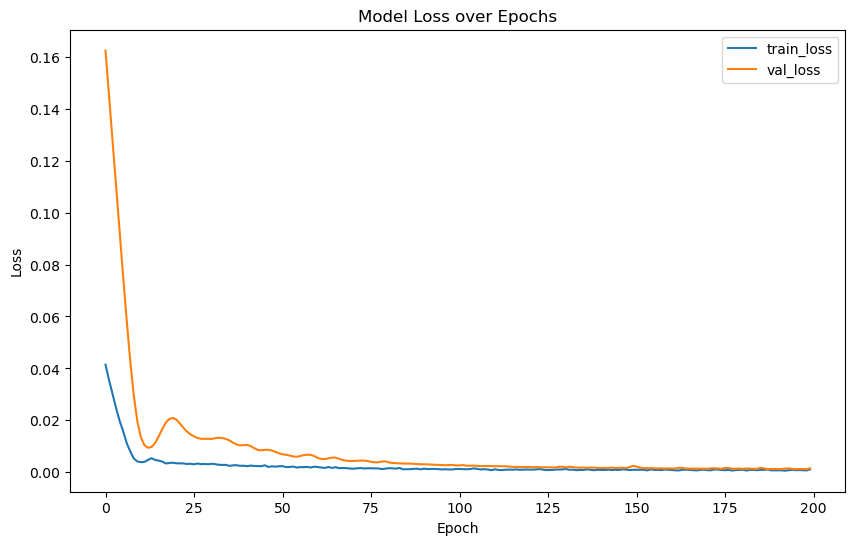

In [13]:
plt.figure(figsize=(10,6))
plt.plot(latih.history['loss'], label='train_loss')
plt.plot(latih.history['val_loss'], label='val_loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

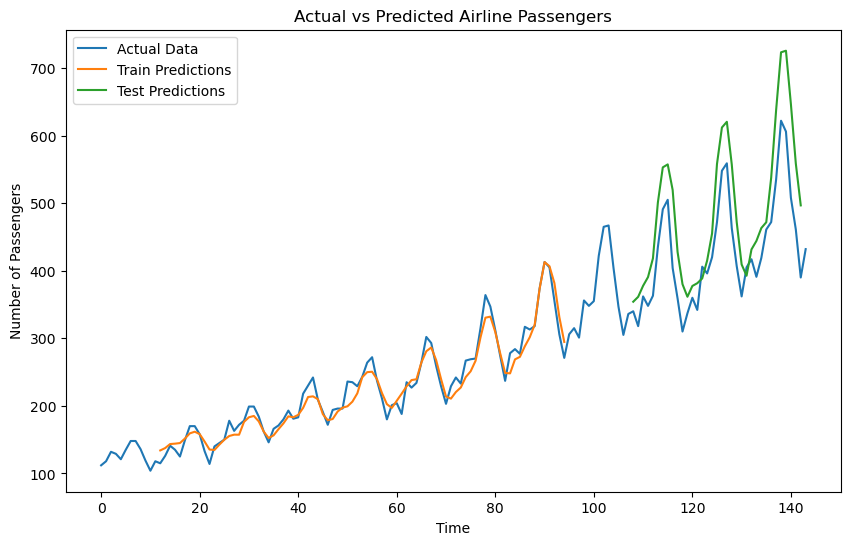

In [14]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# 9. Lakukan prediksi 

Epoch 1/200


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 3s - 861ms/step - loss: 0.0703 - val_loss: 0.3008
Epoch 2/200
3/3 - 0s - 23ms/step - loss: 0.0363 - val_loss: 0.1549
Epoch 3/200
3/3 - 0s - 22ms/step - loss: 0.0141 - val_loss: 0.0520
Epoch 4/200
3/3 - 0s - 22ms/step - loss: 0.0091 - val_loss: 0.0212
Epoch 5/200
3/3 - 0s - 22ms/step - loss: 0.0150 - val_loss: 0.0220
Epoch 6/200
3/3 - 0s - 23ms/step - loss: 0.0104 - val_loss: 0.0341
Epoch 7/200
3/3 - 0s - 21ms/step - loss: 0.0069 - val_loss: 0.0531
Epoch 8/200
3/3 - 0s - 22ms/step - loss: 0.0074 - val_loss: 0.0628
Epoch 9/200
3/3 - 0s - 20ms/step - loss: 0.0091 - val_loss: 0.0584
Epoch 10/200
3/3 - 0s - 25ms/step - loss: 0.0073 - val_loss: 0.0441
Epoch 11/200
3/3 - 0s - 20ms/step - loss: 0.0068 - val_loss: 0.0303
Epoch 12/200
3/3 - 0s - 20ms/step - loss: 0.0064 - val_loss: 0.0234
Epoch 13/200
3/3 - 0s - 20ms/step - loss: 0.0058 - val_loss: 0.0217
Epoch 14/200
3/3 - 0s - 22ms/step - loss: 0.0068 - val_loss: 0.0219
Epoch 15/200
3/3 - 0s - 22ms/step - loss: 0.0051 - val_loss: 0.0231


Epoch 122/200
3/3 - 0s - 22ms/step - loss: 0.0026 - val_loss: 0.0130
Epoch 123/200
3/3 - 0s - 23ms/step - loss: 0.0034 - val_loss: 0.0111
Epoch 124/200
3/3 - 0s - 21ms/step - loss: 0.0032 - val_loss: 0.0125
Epoch 125/200
3/3 - 0s - 20ms/step - loss: 0.0029 - val_loss: 0.0135
Epoch 126/200
3/3 - 0s - 21ms/step - loss: 0.0037 - val_loss: 0.0101
Epoch 127/200
3/3 - 0s - 21ms/step - loss: 0.0029 - val_loss: 0.0180
Epoch 128/200
3/3 - 0s - 21ms/step - loss: 0.0033 - val_loss: 0.0096
Epoch 129/200
3/3 - 0s - 22ms/step - loss: 0.0027 - val_loss: 0.0139
Epoch 130/200
3/3 - 0s - 21ms/step - loss: 0.0028 - val_loss: 0.0165
Epoch 131/200
3/3 - 0s - 20ms/step - loss: 0.0030 - val_loss: 0.0125
Epoch 132/200
3/3 - 0s - 20ms/step - loss: 0.0034 - val_loss: 0.0137
Epoch 133/200
3/3 - 0s - 22ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 134/200
3/3 - 0s - 21ms/step - loss: 0.0031 - val_loss: 0.0164
Epoch 135/200
3/3 - 0s - 21ms/step - loss: 0.0021 - val_loss: 0.0128
Epoch 136/200
3/3 - 0s - 23ms/step

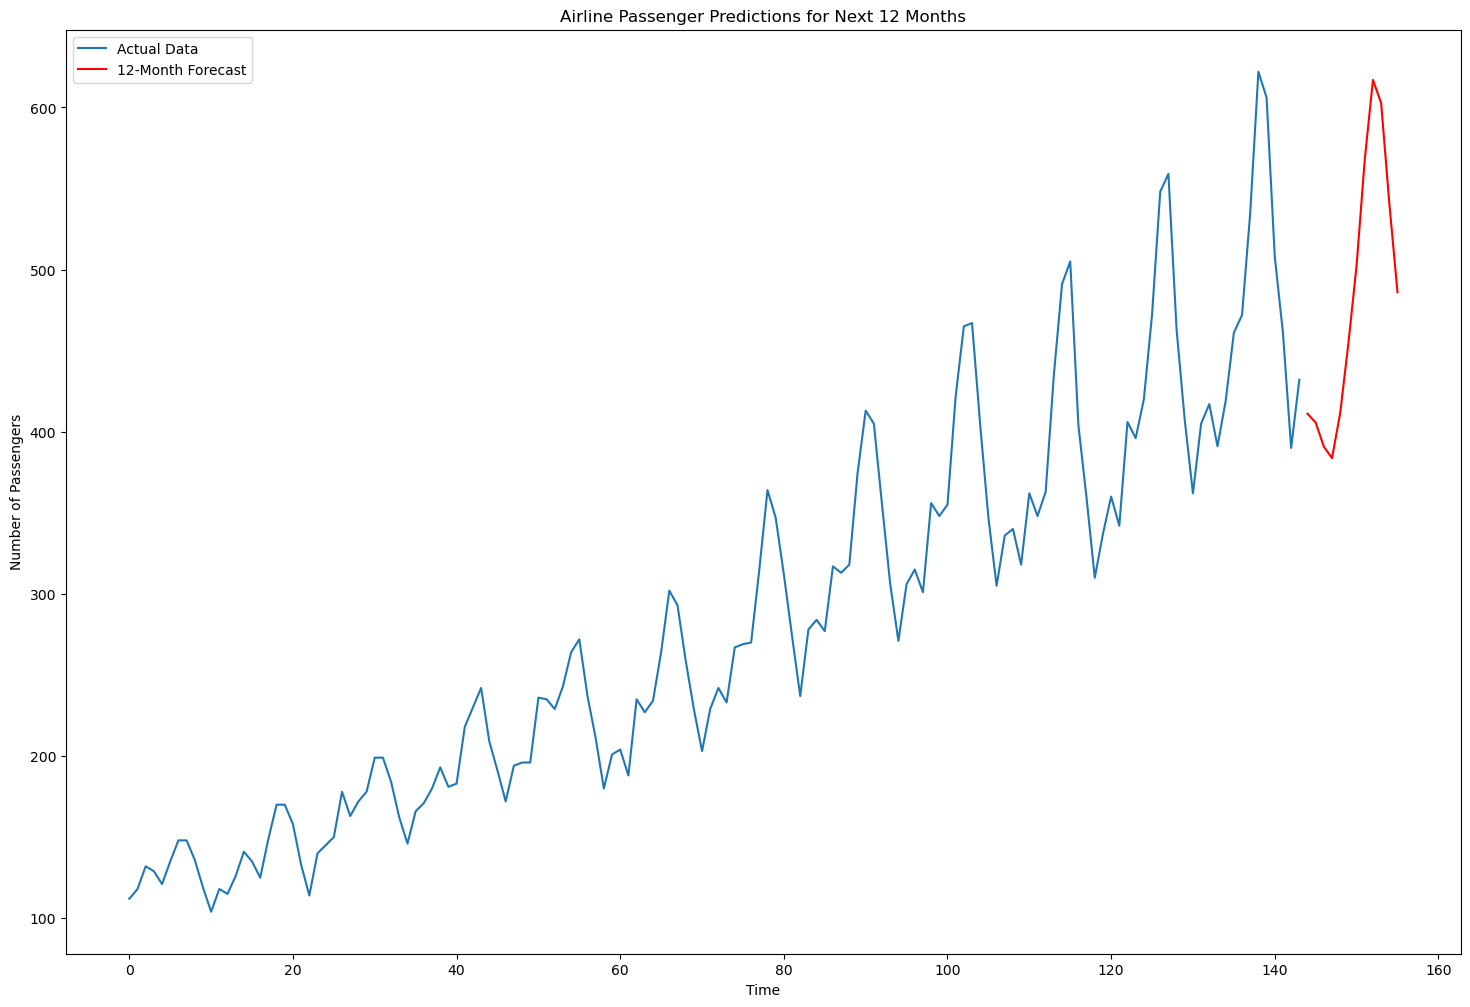

Prediksi Mendatang:
[[411.09293]
 [405.60925]
 [390.7926 ]
 [383.67358]
 [411.73157]
 [454.4998 ]
 [502.5713 ]
 [567.8619 ]
 [616.9576 ]
 [602.7557 ]
 [540.8168 ]
 [486.04126]]


In [15]:
look_back = 12 
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0], look_back, 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

model.fit(trainX, trainY, epochs=200, batch_size=32, validation_data=(testX, testY), verbose=2, callbacks=[early_stopping])

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore_RMSE = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
testScore_RMSE = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
trainScore_MAE = mean_absolute_error(trainY[0], trainPredict[:, 0])
testScore_MAE = mean_absolute_error(testY[0], testPredict[:, 0])

print(f"""berikut adalah hasil trainScore_RMSE = {trainScore_RMSE}""")
print(f"""berikut adalah hasil testScore_RMSE = {testScore_RMSE}""")
print(f"""berikut adalah hasil trainScore_MAE = {trainScore_MAE}""")
print(f"""berikut adalah hasil testScore_MAE = {testScore_MAE}""")

# Prediksi masa depan dengan input batch
initial_input = testX[-1]  
future_predictions = []

# Loop untuk 12 bulan ke depan
current_input = initial_input.reshape(1, look_back, 1)
for _ in range(12):
    next_pred = model.predict(current_input)
    future_predictions.append(next_pred[0, 0])
    current_input = np.roll(current_input, -1, axis=1) 
    current_input[0, -1, 0] = next_pred  

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

plt.figure(figsize=(18, 12))
plt.plot(scaler.inverse_transform(dataset), label='Actual Data')
plt.plot(np.arange(len(dataset), len(dataset) + 12), future_predictions, label='12-Month Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.title('Airline Passenger Predictions for Next 12 Months')
plt.legend()
plt.show()

print("Prediksi Mendatang:")
print(future_predictions)